# Structural virality replication
Date: 1/27/2021

Author: Matthew Sun

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import datetime
import trecs
from trecs.models import BassModel
from trecs.random import SocialGraphGenerator

In [2]:
def calc_avg_degree(graph):
    sum_of_edges = sum(deg for n, deg in graph.degree())
    k = sum_of_edges / graph.number_of_nodes()
    return k

def implied_beta(k, r):
    """ Formula: r = k * beta, so beta equals r/k.
    """
    return r / k

def scale_free_graph(num_nodes, alpha=2.3):
    """ Generate the scale free graph with the degree sequence specified
        by the power law distribution parameterized by alpha. 
    """
    int_seq = np.zeros(num_nodes).astype(int)
    idx = 0
    while idx < num_nodes:
        nextval = int(nx.utils.powerlaw_sequence(1, alpha)[0])
        if idx == num_nodes - 1 and (int_seq.sum() + nextval) % 2 != 0 : # make sure sum is even
            continue
        if nextval > 10 and nextval < 1e6:
            int_seq[idx] = nextval
            idx += 1
    # can't use trecs.SocialGraphGenerator because "n" is not an argument to configuration_model
    # remove self-loops and duplicate edges
    G = nx.configuration_model(int_seq) 
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

In [3]:
G = scale_free_graph(1000, alpha=2.3)
k = calc_avg_degree(G)
print(f"Average degree (k): {k}")
r = 0.5 # if r = 0.5, what is the beta implied?
print(f"Implied infectiousness when r={r}: {implied_beta(k,r)}")

Average degree (k): 25.386
Implied infectiousness when r=0.5: 0.019695895375403765


Text(0.5, 1.0, 'Frequency of degree for nodes in scale-free network')

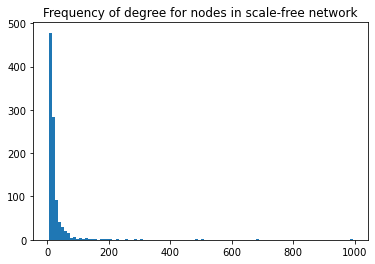

In [4]:
# plot degrees of nodes
degrees = [deg for n, deg in G.degree()]
plt.hist(degrees, bins=100)
plt.title("Frequency of degree for nodes in scale-free network")

In [5]:
def setup_experiment(num_nodes, r=0.5, alpha=2.3):
    G = scale_free_graph(num_nodes, alpha=alpha)
    user_rep = nx.convert_matrix.to_numpy_array(G) # convert to numpy adjacency matrix
    # calculate required item infectiousness
    k = calc_avg_degree(G)
    beta = implied_beta(k, r)
    item_rep = np.array([[beta]]) # must be two dimensional
    
    # seed infection with 1 user
    infection_state = np.zeros(user_rep.shape[0]).reshape(-1, 1) # must be two dimensional array
    seed_user = np.random.choice(num_nodes, 1)
    infection_state[seed_user, 0] = 1
    
    # create model
    bass = BassModel(
        user_representation=user_rep,
        item_representation=item_rep,
        infection_state=infection_state
    )
    return bass

In [6]:
# calculate metrics of interest
def popularity(simulation):
    return (simulation.infection_state != 0).sum()

def graph_popularity(sizes):
    plt.hist(sizes, bins=100)
    plt.title("Frequency of cascade sizes")
    plt.xlabel("Size")
    plt.ylabel("Frequency")
    
def prob_large_cascade(sizes):
    large_cascades = np.where(sizes > 100)[0]
    return len(large_cascades) / len(sizes)

def mean_virality(viralitys):
    # Assume virality of -1 are invalid trials
    # (i.e., the seed user was not able to infect)
    # any other user
    return viralitys[viralitys > -1].mean()

def size_virality_corr(sizes, viralitys):
    """ Calculate correlation between size of cascade
        and structural virality of cascade. Only compute
        correlation on trials where >1 node was infected
        (and therefore structural virality is computable.)
    """
    valid_sims = viralitys > -1 
    stacked_obvs = np.vstack([sizes[valid_sims], viralitys[valid_sims]])
    return np.corrcoef(stacked_obvs)[0, 1]

# Run simulation with 10k users

In [7]:
# test bass model
num_users = 10000
num_trials = 2500

sizes = np.zeros(num_trials)
viralitys = np.zeros(num_trials)


for i in range(num_trials):
    if i % 50 == 0:
        print(f"On trial {i} at time {datetime.datetime.now()}...")
    simulation = setup_experiment(num_users)
    simulation.run()
    size = popularity(simulation)
    sizes[i] = size
    try:
        sv = simulation.get_structural_virality()
        viralitys[i] = sv
    except:
        viralitys[i] = -1 # couldn't calculate virality


On trial 0 at time 2021-01-31 10:06:49.155055...


KeyboardInterrupt: 

In [ ]:
graph_popularity(sizes)

In [ ]:
print(f"Probability of a large cascade: {prob_large_cascade(sizes)}")
print(f"Mean structural virality: {mean_virality(viralitys)}")
print(f"Correlation between popularity and structural virality: {size_virality_corr(sizes, viralitys)}")

# Test with sparse matrices

In [8]:
from scipy.sparse import csr_matrix, save_npz
import pickle as pkl
import os

In [ ]:
num_nodes = 1000000

print(f"Started creating graph at time {datetime.datetime.now()}...")
G = scale_free_graph(num_nodes, alpha=2.3)
print(f"Finished creating graph at time {datetime.datetime.now()}...")
user_rep = nx.convert_matrix.to_scipy_sparse_matrix(G) # convert to scipy adjacency matrix
# calculate required item infectiousness
k = calc_avg_degree(G)
beta = implied_beta(k, r)
item_rep = np.array([[beta]]) # must be two dimensional

# seed infection with 1 user
infection_state = np.zeros(user_rep.shape[0]).reshape(-1, 1) # must be two dimensional array
seed_user = np.random.choice(num_nodes, 1)
infection_state[seed_user, 0] = 1

# create model
bass = BassModel(
    user_representation=user_rep,
    item_representation=item_rep,
    infection_state=infection_state
)
print(f"Finished creating model at time {datetime.datetime.now()}...")

In [12]:
# try to create as many graphs as I can overnight
num_nodes = 1000000
for i in range(75):
    param_dict = {}
    os.mkdir(f"graphs_1m/{i}")
    G = scale_free_graph(num_nodes, alpha=2.3)
    print(f"Finished creating graph {i} at time {datetime.datetime.now()}...")
    user_rep = nx.convert_matrix.to_scipy_sparse_matrix(G) # convert to scipy adjacency matrix
    save_npz(f'graphs_1m/{i}/sparse_matrix.npz', user_rep)
    param_dict["k"] = calc_avg_degree(G)
    param_dict["beta"] = implied_beta(k, r)
    param_dict["num_nodes"] = num_nodes
    f = open(f'graphs_1m/{i}/param.pkl', 'wb')
    pkl.dump(param_dict, f, -1)
    f.close()
    break
    

Finished creating graph 0 at time 2021-01-31 12:22:52.825646...


In [ ]:
bass.run()
size = popularity(bass)
try:
    sv = bass.get_structural_virality()
except:
    pass

In [ ]:
print(size)
print(sv)